# Project 5: Car crash data

## Modeling Notebook
This notebook is for modeling the car crash data.  It assumes that the previous notebooks have been run. 

## Problem Statement:


In [1]:
#imports 
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, f1_score


In [2]:
#read data
crash = pd.read_csv('./data/crash_data_modified.csv')
crash.head()

,Crash Time of Day,Collision Type,Surface Condition,Light,Traffic Control,Driver Substance Abuse,Driver At Fault,Driver Distracted By,Vehicle First Impact Location,Vehicle Second Impact Location,Vehicle Body Type,Vehicle Movement,Speed Limit,Parked Vehicle
0,Evening,SAME DIR REAR END,DRY,DAYLIGHT,STOP SIGN,No,No,No,SIX OCLOCK,SIX OCLOCK,PASSENGER CAR,STOPPED IN TRAFFIC LANE,25,No
1,Early Morning,SAME DIR REAR END,DRY,DAWN,TRAFFIC SIGNAL,No,No,No,SIX OCLOCK,SIX OCLOCK,PASSENGER CAR,STOPPED IN TRAFFIC LANE,40,No
2,Early Morning,SINGLE VEHICLE,DRY,DAYLIGHT,NO CONTROLS,No,No,No,ELEVEN OCLOCK,ELEVEN OCLOCK,POLICE VEHICLE/NON EMERGENCY,MOVING CONSTANT SPEED,35,No
3,Late Night,SINGLE VEHICLE,DRY,DARK LIGHTS ON,NO CONTROLS,No,No,No,TWELVE OCLOCK,TWELVE OCLOCK,POLICE VEHICLE/EMERGENCY,MOVING CONSTANT SPEED,35,No
4,Night,SAME DIR REAR END,DRY,DARK LIGHTS ON,NO CONTROLS,Yes,Yes,Yes,TWELVE OCLOCK,TWELVE OCLOCK,PASSENGER CAR,ACCELERATING,35,No


In [3]:
# original feature names
crash.columns

Index(['Crash Time of Day', 'Collision Type', 'Surface Condition', 'Light',
       'Traffic Control', 'Driver Substance Abuse', 'Driver At Fault',
       'Driver Distracted By', 'Vehicle First Impact Location',
       'Vehicle Second Impact Location', 'Vehicle Body Type',
       'Vehicle Movement', 'Speed Limit', 'Parked Vehicle'],
      dtype='object')

## Basic look at occurences of features in data

In [4]:
# Driver substance abuse
crash['Driver Substance Abuse'].value_counts(normalize = True)

No     0.973233
Yes    0.026767
Name: Driver Substance Abuse, dtype: float64

In [5]:
# Driver distracted by
crash['Driver Distracted By'].value_counts(normalize = True)

No     0.784361
Yes    0.215639
Name: Driver Distracted By, dtype: float64

## Handling categorical variables (one-hot encoding)

In [98]:
columns_to_dummify = ['Crash Time of Day', 'Collision Type', 'Surface Condition', 'Light',
       'Traffic Control', 'Vehicle First Impact Location',
       'Vehicle Second Impact Location', 'Vehicle Body Type',
       'Vehicle Movement', 'Parked Vehicle']

df = pd.get_dummies(crash,columns=columns_to_dummify, drop_first=True)

In [99]:
df = pd.get_dummies(crash, columns = columns_to_dummify)

In [100]:
df.drop (columns = ['Traffic Control_NO CONTROLS', 
                    'Surface Condition_DRY', 
                    'Crash Time of Day_Noon', 
                    'Light_DAYLIGHT', 
                    'Vehicle Movement_MOVING CONSTANT SPEED'], 
         inplace = True)

In [101]:
df['Driver At Fault'] = df['Driver At Fault'].map({'No':0, 'Yes':1})
df['Driver Substance Abuse'] = df['Driver Substance Abuse'].map({'No':0, 'Yes':1})
df['Driver Distracted By'] = df['Driver Distracted By'].map({'No':0, 'Yes':1})

In [102]:
df.head()

,Driver Substance Abuse,Driver At Fault,Driver Distracted By,Speed Limit,Crash Time of Day_Early Morning,Crash Time of Day_Evening,Crash Time of Day_Late Night,Crash Time of Day_Morning,Crash Time of Day_Night,Collision Type_ANGLE MEETS LEFT HEAD ON,...,Vehicle Movement_PARKING,Vehicle Movement_PASSING,Vehicle Movement_RIGHT TURN ON RED,Vehicle Movement_SKIDDING,Vehicle Movement_SLOWING OR STOPPING,Vehicle Movement_STARTING FROM LANE,Vehicle Movement_STARTING FROM PARKED,Vehicle Movement_STOPPED IN TRAFFIC LANE,Parked Vehicle_No,Parked Vehicle_Yes
0,0,0,0,25,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1,0,0,0,40,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
2,0,0,0,35,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,35,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,1,1,35,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


## Setting up our features and target

In [103]:
# get X and y; train,test,split the data
X = df.drop(columns = 'Driver At Fault')
y = df['Driver At Fault']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=13424)

## Modeling

### Null Model

In [104]:
df['Driver At Fault'].value_counts(normalize = True)

0    0.556386
1    0.443614
Name: Driver At Fault, dtype: float64

For this data set 55.6% of the crashes were listed as the driver not at fault.  This means that if we assign the driver as never at fault we would have a baseline accuracy of 55.6%.  

### Simple Logistic Regression Model

In [105]:
# logistic regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [106]:
print('Logistic Regression metrics\n')
print('           training           testing')
print('Accuracy: ',logreg.score(X_train,y_train),logreg.score(X_test,y_test))
print('f1:       ',f1_score(y_train,logreg.predict(X_train)),f1_score(y_test,logreg.predict(X_test)))

Logistic Regression metrics

           training           testing
Accuracy:  0.8908028640830647 0.8935511526004953
f1:        0.8757676468463261 0.8793522267206477


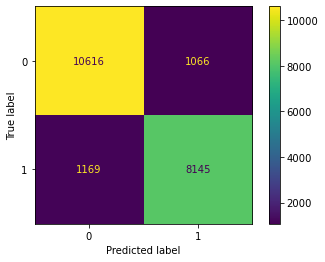

In [107]:
# confusion matrix
plot_confusion_matrix(logreg,X_test,y_test);

For the logistic regression model, the confusion matrix is fairly balanced with only slightly more Type II errors than Type I errors.  It has a fairly high accuracy and fairly high f1 score.  

In [108]:
# dataframe from the fit coefficients
logreg_coef_dict = {entry[0]:entry[1] for entry in list(zip(X.columns, logreg.coef_[0]))}
logreg_coef_df = pd.DataFrame(logreg_coef_dict.values(), index = logreg_coef_dict.keys())
logreg_coef_df.columns = ['logreg coef']

### Decision Tree Modeling

In [109]:
tree = DecisionTreeClassifier(max_depth=5)
tree.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=5)

In [110]:
print('Decision Tree metrics\n')
print('           training           testing')
print('Accuracy: ', tree.score(X_train,y_train),tree.score(X_test,y_test))
print('f1:       ',f1_score(y_train,tree.predict(X_train)),f1_score(y_test,tree.predict(X_test)))

Decision Tree metrics

           training           testing
Accuracy:  0.8749900773175417 0.8760240045722995
f1:        0.8523975555805495 0.8538707685398305


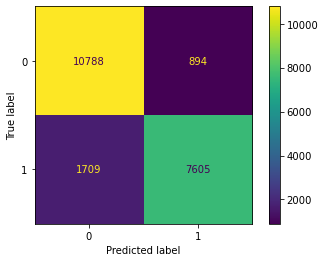

In [111]:
plot_confusion_matrix(tree,X_test,y_test);

For the decision tree model, the confusion matrix is unbalanced with vastly more Type II errors than Type I errors.  It has a fairly high accuracy and fairly high f1 score though.  

In [112]:
tree_imp_dict = {entry[0]:entry[1] for entry in list(zip(X.columns,tree.feature_importances_))}
tree_imp_df = pd.DataFrame(tree_imp_dict.values(), index = tree_imp_dict.keys())
tree_imp_df.columns = ['tree importance']
tree_imp_df.sort_values(by = ['tree importance'], ascending= False).head(20)

,tree importance
Driver Distracted By,0.503336
Vehicle First Impact Location_SIX OCLOCK,0.180337
Collision Type_SAME DIR REAR END,0.113551
Collision Type_SINGLE VEHICLE,0.083383
Vehicle Movement_MAKING LEFT TURN,0.048773
Vehicle Second Impact Location_TWELVE OCLOCK,0.035752
Vehicle Movement_STOPPED IN TRAFFIC LANE,0.011977
Vehicle Movement_BACKING,0.009246
Vehicle Second Impact Location_ONE OCLOCK,0.004326
Vehicle Body Type_POLICE VEHICLE/NON EMERGENCY,0.003806


The feature importances for the decision tree model are different than for the logistic regression model.  

The tree model also shows driver distraction is the key indicator of driver responsibility in a crash.  

This also has driver substance abuse of lower importance than the in the logistic regression model.  This is very interesting and we should investigate further.  

### Random Forest

In [113]:
forest = RandomForestClassifier(max_depth = 14)
forest.fit(X_train,y_train)

RandomForestClassifier(max_depth=14)

In [114]:
print('Random Forest metrics\n')
print('           training           testing')
print('Accuracy:',forest.score(X_train,y_train),forest.score(X_test,y_test))
print('f1:      ',f1_score(y_train,forest.predict(X_train)),f1_score(y_test,forest.predict(X_test)))

Random Forest metrics

           training           testing
Accuracy: 0.9068220426437201 0.899171270718232
f1:       0.89153375593709 0.8830709748688208


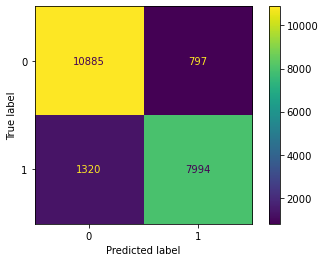

In [115]:
plot_confusion_matrix(forest,X_test,y_test);

For the random forest model, the confusion matrix is fairly balanced with slightly more Type II errors than Type I errors.  It has a high accuracy and high f1 score.  

In [116]:
forest_imp_dict = {entry[0]:entry[1] for entry in list(zip(X.columns,forest.feature_importances_))}
forest_imp_df = pd.DataFrame(forest_imp_dict.values(), index = forest_imp_dict.keys())
forest_imp_df.columns = ['forest importance']
forest_imp_df.sort_values(by = ['forest importance'], ascending= False).head(20)

,forest importance
Driver Distracted By,0.265350
Vehicle First Impact Location_SIX OCLOCK,0.132117
Vehicle Second Impact Location_SIX OCLOCK,0.089251
Collision Type_SAME DIR REAR END,0.085129
Vehicle Movement_STOPPED IN TRAFFIC LANE,0.050092
Vehicle Second Impact Location_TWELVE OCLOCK,0.046538
Vehicle First Impact Location_TWELVE OCLOCK,0.044964
Collision Type_SINGLE VEHICLE,0.041847
Vehicle Movement_MAKING LEFT TURN,0.041488
Collision Type_STRAIGHT MOVEMENT ANGLE,0.023373


The random forest shows similar feature importances to the tree and has about 5 points higher accuracy.  



## Model metrics

In [117]:
## model comparison
models = [logreg,tree,forest]
model_metrics = [(model.score(X_train,y_train), 
                  model.score(X_test,y_test),
                  f1_score(y_train,model.predict(X_train)),
                  f1_score(y_test,model.predict(X_test))
                 ) for model in models]
metrics_df = pd.DataFrame(model_metrics, 
                          columns = ['training_accuracy', 
                                     'testing_accuracy',
                                     'training_f1',
                                     'testing_f1'
                                    ], 
                          index = ['logreg','tree','forest'])
null_acc = df['Driver At Fault'].value_counts(normalize = True)[0]
metrics_df.loc[metrics_df.shape[0]] = [null_acc, null_acc, 'undefined', 'undefined']

metrics_df.index = ['logreg','tree','forest', 'null']

metrics_df.head()

,training_accuracy,testing_accuracy,training_f1,testing_f1
logreg,0.890803,0.893551,0.875768,0.879352
tree,0.874990,0.876024,0.852398,0.853871
forest,0.906822,0.899171,0.891534,0.883071
null,0.556386,0.556386,undefined,undefined


Comparing the models, the logistic regression and random forest both do quite well.  The forest has a slightly better testing accuracy and f1 score but shows slightly more variance.  All the models outperform the null model in which we assign all cases to be 0 (driver not at fault).  

The random forest shows slightly better scores and provides information about feature importance.  However, it does not indicate if the importance is telling us it is positively correlated or negatively correlated with fault in an accident.  For this reason, we will examine the logistic regression coefficients in addition to the random forest feature importance.  

## Model Output

We will look at the most important individual features in determining fault as well as the most important within a given category.   

### Most important features overall

In [118]:
results = pd.merge(left = forest_imp_df,right = logreg_coef_df, left_index=True, right_index=True)

In [165]:
important_features = forest_imp_df.sort_values('forest importance', ascending = False).head(10)

In [163]:
forest_imp_df.sort_values('forest importance', ascending = False).head(10)

,forest importance
Driver Distracted By,0.265350
Vehicle First Impact Location_SIX OCLOCK,0.132117
Vehicle Second Impact Location_SIX OCLOCK,0.089251
Collision Type_SAME DIR REAR END,0.085129
Vehicle Movement_STOPPED IN TRAFFIC LANE,0.050092
Vehicle Second Impact Location_TWELVE OCLOCK,0.046538
Vehicle First Impact Location_TWELVE OCLOCK,0.044964
Collision Type_SINGLE VEHICLE,0.041847
Vehicle Movement_MAKING LEFT TURN,0.041488
Collision Type_STRAIGHT MOVEMENT ANGLE,0.023373


In [164]:
logreg_coef_df.sort_values('logreg coef', ascending = False).head(10)

,logreg coef
Vehicle Movement_BACKING,6.108053
Driver Distracted By,3.955130
Vehicle Movement_CHANGING LANES,3.692386
Vehicle Movement_MAKING U TURN,3.512027
Vehicle Movement_PASSING,3.131283
Driver Substance Abuse,3.071846
Vehicle Movement_ENTERING TRAFFIC LANE,3.054638
Vehicle Movement_RIGHT TURN ON RED,2.521771
Vehicle Movement_MAKING LEFT TURN,2.480264
Collision Type_SAME DIR REAR END,2.177790


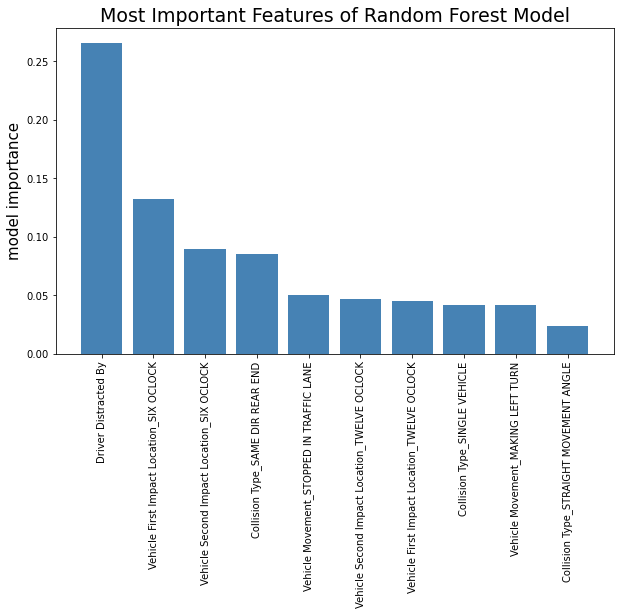

In [173]:
plt.figure(figsize=(10,6))
plt.bar(x = important_features.index, 
        height = important_features['forest importance'], 
        color = 'steelblue');
plt.title('Most Important Features of Random Forest Model', size = 19);
plt.xticks(rotation = 90);
plt.ylabel('model importance', size = 15)
#plt.xlabel('model feature', size = 15)
plt.savefig('./images/most_important_features.png', format='png')

In [182]:
high_coefs = logreg_coef_df.sort_values('logreg coef', ascending = False).head(10)

In [188]:
low_coefs = logreg_coef_df.sort_values('logreg coef', ascending = True).head(10)

In [192]:
important_coefs = pd.concat([high_coefs,low_coefs])
important_coefs.sort_values('logreg coef', ascending = False, inplace = True);

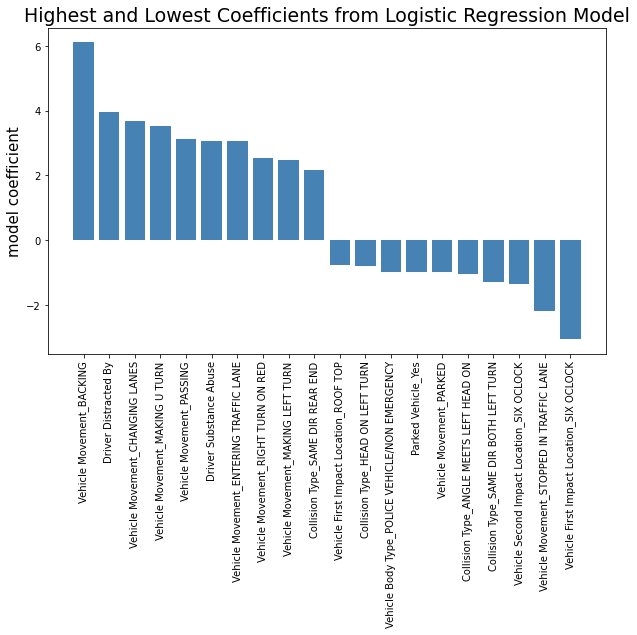

In [193]:
plt.figure(figsize=(10,6))
plt.bar(x = important_coefs.index, 
        height = important_coefs['logreg coef'], 
        color = 'steelblue');
plt.title('Highest and Lowest Coefficients from Logistic Regression Model', size = 19);
plt.xticks(rotation = 90);
plt.ylabel('model coefficient', size = 15)
#plt.xlabel('model feature', size = 15)
plt.savefig('./images/high_low_coef.png', format='png')

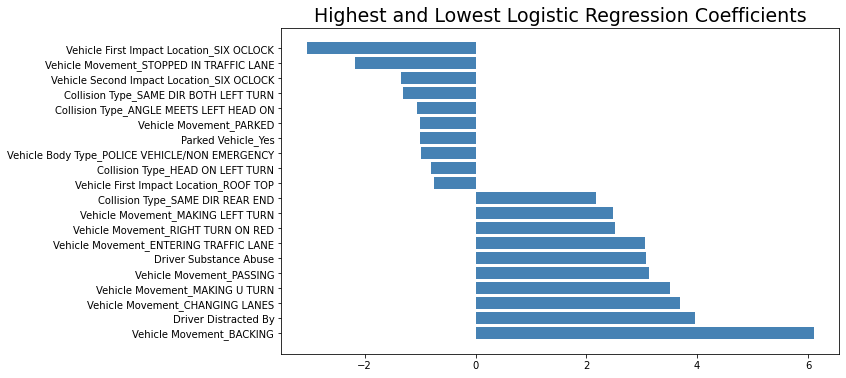

In [196]:
plt.figure(figsize=(10,6))
plt.barh(y = important_coefs.index, 
        width = important_coefs['logreg coef'], 
        color = 'steelblue');
plt.title('Highest and Lowest Logistic Regression Coefficients', size = 19);
#plt.xticks(rotation = 90);
#plt.ylabel('model coefficient', size = 15)
#plt.xlabel('model feature', size = 15)
plt.savefig('./images/high_low_coef.png', format='png')

### Most important features within a category
Isolating original features and examining which values contribute most to our undestanding of fault in the accident.  We use the logistic regression coefficients for categorical variables which tell us the increase/decrease compared to a default conditions shown below.  


|Feature| Default condition|
|---|---|
|time of day| noon|
|lighting | daylight|
|surface condition | dry|
|traffic control| no controls|
|vehicle movement| moving constant speed|

#### Time of day

Default time of day is `Noon`.

None of the time of day categories show high importance in determining fault with all options grouped fairly close in importance.  

Crashes in`Evening` and `Night` were less likely to be driver-caused than crashes as `Noon`.  Crashes `Late Night`, `Morning`, and `Early Morning` were more likely to be driver caused than crashes at `Noon`.    



In [121]:
#forest
forest_imp_df[forest_imp_df.index.str.contains('Time')].sort_values('forest importance', ascending = False)

,forest importance
Crash Time of Day_Evening,0.001325
Crash Time of Day_Morning,0.001207
Crash Time of Day_Night,0.000947
Crash Time of Day_Early Morning,0.000870
Crash Time of Day_Late Night,0.000736


In [122]:
logreg_coef_df[logreg_coef_df.index.str.contains('Time')].sort_values('logreg coef', ascending = True)

,logreg coef
Crash Time of Day_Evening,-0.083880
Crash Time of Day_Night,-0.049740
Crash Time of Day_Late Night,0.003007
Crash Time of Day_Morning,0.054543
Crash Time of Day_Early Morning,0.131780


#### Surface Conditions

Default surface condition is `DRY`.

Compared to dry conditions, 

In [123]:
forest_imp_df[forest_imp_df.index.str.contains('Surface')].sort_values('forest importance', ascending = False)

,forest importance
Surface Condition_WET,0.001891
Surface Condition_ICE,0.000497
Surface Condition_SNOW,0.000383
"Surface Condition_MUD, DIRT, GRAVEL",0.000069
Surface Condition_WATER(STANDING/MOVING),0.000056
Surface Condition_SLUSH,0.000053
Surface Condition_OIL,0.000006
Surface Condition_SAND,0.000000


In [124]:
logreg_coef_df[logreg_coef_df.index.str.contains('Surface')].sort_values('logreg coef', ascending = False)

,logreg coef
Surface Condition_SNOW,0.856885
Surface Condition_ICE,0.620794
Surface Condition_WET,0.260551
Surface Condition_WATER(STANDING/MOVING),0.141917
Surface Condition_SAND,0.028466
Surface Condition_SLUSH,-0.002184
Surface Condition_OIL,-0.023942
"Surface Condition_MUD, DIRT, GRAVEL",-0.708325


#### Traffic Control

Default for traffic control is `NO CONTROLS`.  

Compared to no controls, `WARNING SIGN`, `RAILWAY CROSSING DEVICE`, `FLASHING TRAFFIC SIGNAL`, `YIELD SIGN`, and `SCHOOL ZONE SIGN DEVICE` are all mild indicators of driver fault.  They are, however, very low on the list of important features.  

In [126]:
forest_imp_df[forest_imp_df.index.str.contains('Traffic Control')].sort_values('forest importance', ascending = False)

,forest importance
Traffic Control_TRAFFIC SIGNAL,5.711106e-03
Traffic Control_STOP SIGN,4.121950e-03
Traffic Control_FLASHING TRAFFIC SIGNAL,3.979654e-04
Traffic Control_YIELD SIGN,3.265717e-04
Traffic Control_PERSON,6.246759e-05
Traffic Control_WARNING SIGN,2.745640e-05
Traffic Control_RAILWAY CROSSING DEVICE,1.886648e-05
Traffic Control_SCHOOL ZONE SIGN DEVICE,3.859134e-07


In [127]:
logreg_coef_df[logreg_coef_df.index.str.contains('Control')].sort_values('logreg coef', ascending = False)

,logreg coef
Traffic Control_WARNING SIGN,0.566574
Traffic Control_RAILWAY CROSSING DEVICE,0.388825
Traffic Control_FLASHING TRAFFIC SIGNAL,0.276344
Traffic Control_YIELD SIGN,0.116923
Traffic Control_SCHOOL ZONE SIGN DEVICE,0.090265
Traffic Control_STOP SIGN,-0.092641
Traffic Control_TRAFFIC SIGNAL,-0.093000
Traffic Control_PERSON,-0.393253


#### Light Conditions

Default for light is `DAYLIGHT`.  

Compared to daylight, all other light situations are negatively correlated with driver fault.  That is, the driver is less likely to be responsible in dark conditions than in light conditions.  

In [128]:
forest_imp_df[forest_imp_df.index.str.contains('Light')].sort_values('forest importance', ascending = False)

,forest importance
Light_DARK LIGHTS ON,0.001390
Light_DARK NO LIGHTS,0.000677
Light_DAWN,0.000456
Light_DUSK,0.000375
Light_DARK -- UNKNOWN LIGHTING,0.000238


In [129]:
logreg_coef_df[logreg_coef_df.index.str.contains('Light')].sort_values('logreg coef', ascending = False)

,logreg coef
Light_DUSK,-0.072055
Light_DARK LIGHTS ON,-0.149331
Light_DAWN,-0.218778
Light_DARK NO LIGHTS,-0.258096
Light_DARK -- UNKNOWN LIGHTING,-0.411316


#### Vehicle movement

Default vehicle movement is `MOVING CONSTANT SPEED`.

The most important feature is `STOPPED IN TRAFFIC LANE` which, holding all else equal, is more strongly negatively correlated with driver fault than teh default of `MOVING CONSTANT SPEED`.  Similarly, `SLOWING OR STOPPING` and `PARKED` show lower chance of driver fault in an accident than traveling at a constant speed.  

Comparing coefficients we see that driver fault is least likely when `STOPPED IN TRAFFIC LANE` and most likely when `BACKING`.  


In [131]:
forest_imp_df[forest_imp_df.index.str.contains('Movement')].sort_values('forest importance', ascending = False)

,forest importance
Vehicle Movement_STOPPED IN TRAFFIC LANE,0.050092
Vehicle Movement_MAKING LEFT TURN,0.041488
Vehicle Movement_CHANGING LANES,0.015798
Vehicle Movement_SLOWING OR STOPPING,0.012026
Vehicle Movement_ACCELERATING,0.008516
Vehicle Movement_BACKING,0.007257
Vehicle Movement_MAKING RIGHT TURN,0.006948
Vehicle Movement_MAKING U TURN,0.002657
Vehicle Movement_PASSING,0.002293
Vehicle Movement_ENTERING TRAFFIC LANE,0.001724


In [132]:
logreg_coef_df[logreg_coef_df.index.str.contains('Movement')].sort_values('logreg coef', ascending = False)

,logreg coef
Vehicle Movement_BACKING,6.108053
Vehicle Movement_CHANGING LANES,3.692386
Vehicle Movement_MAKING U TURN,3.512027
Vehicle Movement_PASSING,3.131283
Vehicle Movement_ENTERING TRAFFIC LANE,3.054638
Vehicle Movement_RIGHT TURN ON RED,2.521771
Vehicle Movement_MAKING LEFT TURN,2.480264
Vehicle Movement_SKIDDING,2.089081
Vehicle Movement_LEAVING TRAFFIC LANE,2.035851
Vehicle Movement_MAKING RIGHT TURN,2.026153


#### Substance Abuse

As expected, substance abuse is a highly important feature with strong, positive correlation with fault in the accident. 

In [133]:
forest_imp_df[forest_imp_df.index.str.contains('Substance Abuse')].sort_values('forest importance', ascending = False)

,forest importance
Driver Substance Abuse,0.015609


In [134]:
logreg_coef_df[logreg_coef_df.index.str.contains('Substance Abuse')].sort_values('logreg coef', ascending = False)

,logreg coef
Driver Substance Abuse,3.071846


## To do: 
- collect results and write a few sentences about each
- 